In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
#Loading the data into a numpy array
data = np.loadtxt('datafile-expresonance(1).txt',unpack=True,dtype=float)

## Part 1

In [3]:
def log_likelihood_gauss(f,mean,tau):
    """This is the maximum likelihood function for the exp distribution with the Gaussian distribution"""
    sigma = 0.2 #pre-defined width
    exponential = np.exp(-data/tau) # exponential distribution
    exponential_norm = 1/(tau*(np.exp(-0/tau)-np.exp(-10/tau))) # exponential normalisation
    gauss = np.exp(-np.square(data-mean)/(2*np.square(sigma))) #normal distribution
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma) #gaussian normalisation
    total = (f*exponential*exponential_norm)+((1-f)*gauss*gauss_norm) # Combining them relative to fraction
    total[total < 1e-4] = 1e-4 # Clip values too small for the logarithm
    
    return -np.sum(np.log(total))

In [4]:
#Using minuit to optimize values

log_likelihood_gauss.errordef = Minuit.LIKELIHOOD # Tells Minuit to use log-likelihood for the error matrix (0.5)


m2 = Minuit(log_likelihood_gauss, f = 0.2, mean=2., tau=1.) # Uses log-likelihood function with the stated guesses
m2.migrad() # runs the minimisation

print("Best fit values calculated by minuit are:")
print("")
print("fraction = "+str(round(np.asarray(m2.values)[0],4))+" +/- "+str(round(np.asarray(m2.errors)[0],4)))
print("")
print("mean = "+str(round(np.asarray(m2.values)[1],4))+" +/- "+str(round(np.asarray(m2.errors)[1],4)))
print("")
print("tau = "+str(round(np.asarray(m2.values)[2],4))+" +/- "+str(round(np.asarray(m2.errors)[2],4)))

Best fit values calculated by minuit are:

fraction = 0.9796 +/- 0.0012

mean = 2.4985 +/- 0.0146

tau = 5.0078 +/- 0.0307


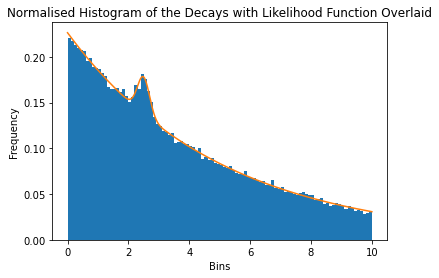

In [5]:
#Check to see if the fit looks acceptable

def function(f,mean,tau):
    """This function defines the combined normal and exponential distribution"""
    sigma = 0.2
    exponential = np.exp(-values/tau)
    exponential_norm = 1/(tau*(np.exp(-0/tau)-np.exp(-10/tau)))
    gauss = np.exp(-np.square(values-mean)/(2*np.square(sigma)))
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma)
    total = (f*exponential*exponential_norm)+((1-f)*gauss*gauss_norm)
    
    return total

values = np.linspace(0,10,1000)

#Plotting the function over the histogram
plt.hist(data,bins=100,density=True)
plt.plot(values,function(np.asarray(m2.values)[0],np.asarray(m2.values)[1],np.asarray(m2.values)[2]))
plt.title('Normalised Histogram of the Decays with Likelihood Function Overlaid')
plt.xlabel("Bins")
plt.ylabel('Frequency')
plt.show()

#The fit looks acceptable

## Part 2

#### Note: Due to the ambiguity behind the meaning of the phrase "shift method", I followed both method 1 & method 2 as described in the lecture notes to calculate the systematic errors. Both give the same answer, but I have included them separately nonetheless.

In [6]:
def polynomial(f,G,ba,ca):
    """This function fits a 2nd order polynomial for the background"""
    sigma = 0.2 #pre-defined width
    background = 1+(ba*data)+(ca*(data**2)) # 2nd order polynomial
    background_norm = 1/(10+50*ba+(1000/3)*ca) # polynomial normalisation (integrated from 0-10)
    gauss = np.exp(-np.square(data-G)/(2*np.square(sigma))) #normal distribution
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma) #gaussian normalisation
    total = (f*background*background_norm)+((1-f)*gauss*gauss_norm) # Combining them relative to fraction
    total[total < 1e-4] = 1e-4 # Clip values too small for the logarithm
    
    return -np.sum(np.log(total))


In [7]:
#method 1

#fitting for the polynomial background
polynomial.errordef = Minuit.LIKELIHOOD # Tells Minuit to use log-likelihood for the error matrix (0.5)

mp1 = Minuit(polynomial, f = 0.98, G=2.5, ba=-0.016, ca=0.007) # Uses log-likelihood function with the stated guesses
mp1.migrad() # runs the minimisation

mp2 = Minuit(polynomial, f = 0.98, G=2.5+mp1.errors[1], ba=-0.016, ca=0.007) #Uses the value plus error as starting guess
mp2.migrad() # runs the minimisation

pshift_meth1 = abs(m2.values[1]-mp2.values[1]) #Finding the difference between the two values


In [8]:
#method 2


#Create a gaussian distribution centred on the mean and with width equal to the error on the mean
#Then pick values of G inside and run the fits
shift_mean = []
count = 0

while count<100:
    g = np.random.normal(loc=m2.values[1],scale=m2.errors[1])
    mp2 = Minuit(polynomial, f = 0.98, G=g, ba=-0.016, ca=0.007) # Uses log-likelihood function with the stated guesses
    mp2.migrad() # runs the minimisation
    mp3 = Minuit(log_likelihood_gauss, f = 0.98, mean=g, tau=5.) #runs minimusation for exponential background
    mp3.migrad()
    shift_mean.append(mp3.values[1]-mp2.values[1])
    count+=1

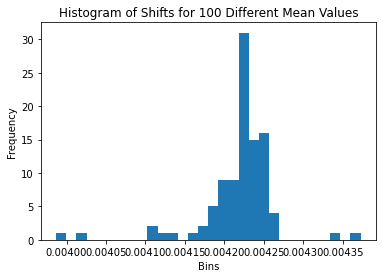

In [9]:
plt.hist(shift_mean,bins=30)
plt.title("Histogram of Shifts for 100 Different Mean Values")
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()
#This graph is a narrow gaussian distribution centred on 0.004

In [10]:
total_e_1 = np.sqrt(np.square(pshift_meth1)+np.square(np.asarray(mp1.errors)[1]))#adding errors in quadrature
print("Via Method 1:")
print("")
print("Mean = {:.4f} +/- {:.4f} +/- {:.4f}".format(np.asarray(mp1.values)[1],np.asarray(mp1.errors)[1],pshift_meth1))
print("")
print("Mean = {:.4f} +/- {:.4f}".format(np.asarray(mp1.values)[1],total_e_1))


sys_e = np.mean(shift_mean) # The systematic error is the mean of the normal distribution
total_e_2 = np.sqrt(np.square(sys_e)+np.square(np.asarray(mp1.errors)[1]))#adding errors in quadrature
print("")
print("Via Method 2:")
print("")
print("Mean = {:.4f} +/- {:.4f} +/- {:.4f}".format(np.asarray(mp1.values)[1],np.asarray(mp1.errors)[1],sys_e))
print("")
print("Mean = {:.4f} +/- {:.4f}".format(np.asarray(mp1.values)[1],total_e_2))

Via Method 1:

Mean = 2.4943 +/- 0.0156 +/- 0.0042

Mean = 2.4943 +/- 0.0162

Via Method 2:

Mean = 2.4943 +/- 0.0156 +/- 0.0042

Mean = 2.4943 +/- 0.0162


We can see here that the systematic error is not very important compared to the statistical error as it is much smaller. In fact, the total error is only very slightly larger than the statistical error so the systematic error has a very small effect. Therefore, the polynomial fit for the background is not too bad and would still give similar results. Also note that the two different methods used both correspond to the same systematic error.

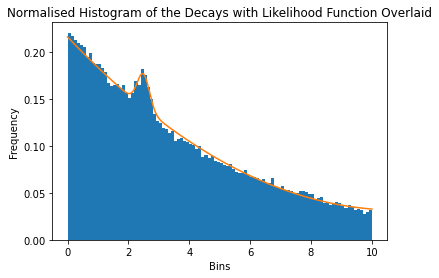

In [11]:
#Check to see how good the fit looks

def function_poly(f,mean,ba,ca):
    """This function defines the combined normal distribution and polynomial"""
    sigma = 0.2
    background = 1+(ba*values)+(ca*(values**2)) # 2nd order polynomial
    background_norm = 1/(10+50*ba+(1000/3)*ca) # polynomial normalisation
    gauss = np.exp(-np.square(values-mean)/(2*np.square(sigma)))
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma)
    total = (f*background*background_norm)+((1-f)*gauss*gauss_norm)
    
    return total

values = np.linspace(0,10,1000)

plt.hist(data,bins=100,density=True)
plt.plot(values,function_poly(np.asarray(mp1.values)[0],np.asarray(mp1.values)[1],np.asarray(mp1.values)[2],np.asarray(mp1.values)[3]))
plt.title('Normalised Histogram of the Decays with Likelihood Function Overlaid')
plt.xlabel("Bins")
plt.ylabel('Frequency')
plt.show()

#Not quite as good as above but still acceptable, in my opinion. 

## Part 3

In [12]:
def linear(f,G,da):
    """This function fits a linear fit for the background"""
    sigma = 0.2 #pre-defined width
    background = 1+(da*data) # linear function
    background_norm = 1/(10+(50*da)) # linear normalisation
    gauss = np.exp(-np.square(data-G)/(2*np.square(sigma))) #normal distribution
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma) #gaussian normalisation
    total = (f*background*background_norm)+((1-f)*gauss*gauss_norm) # Combining them relative to fraction
    total[total < 1e-4] = 1e-4 # Clip values too small for the logarithm
    
    return -np.sum(np.log(total))

In [13]:
#method 1

#fitting for the polynomial background
linear.errordef = Minuit.LIKELIHOOD # Tells Minuit to use log-likelihood for the error matrix (0.5)

ml1 = Minuit(linear, f = 0.98, G=2.5, da=-0.09) # Uses log-likelihood function with the stated guesses
ml1.migrad() # runs the minimisation

ml2 = Minuit(linear, f = 0.98, G=2.5+ml1.errors[1], da=-0.09) #Uses the value plus error as starting guess
ml2.migrad() # runs the minimisation

lshift_meth1 = abs(m2.values[1]-ml2.values[1])

In [14]:
#method 2

#Create a gaussian distribution centred on the mean and with width equal to the error on the mean
#Then pick values of G inside and run the fit
shift_mean_l = []
count = 0

while count<100:
    g = np.random.normal(loc=ml1.values[1],scale=ml1.errors[1])
    ml2 = Minuit(linear, f = 0.98, G=g, da=-0.09) # Uses log-likelihood function with the stated guesses
    ml2.migrad() # runs the minimisation
    ml3 = Minuit(log_likelihood_gauss, f = 0.98, mean=g, tau=5.)
    ml3.migrad()
    shift_mean_l.append(ml3.values[1]-ml2.values[1])
    count+=1

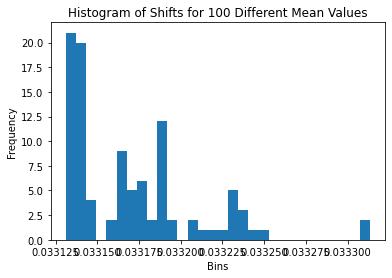

In [15]:
plt.hist(shift_mean_l,bins=30)
plt.title("Histogram of Shifts for 100 Different Mean Values")
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()
#Strangely, this appears nothing like a gaussian but the mean still corresponds to the value found in method 1

In [16]:

total_e_l_1 = np.sqrt(np.square(lshift_meth1)+np.square(np.asarray(ml1.errors)[1]))
print("Via Method 1:")
print("")
print("Mean = {:.4f} +/- {:.4f} +/- {:.4f}".format(np.asarray(ml1.values)[1],np.asarray(ml1.errors)[1],lshift_meth1))
print("")
print("Mean = {:.4f} +/- {:.4f}".format(np.asarray(ml1.values)[1],total_e_l_1))

lshift_meth2 = np.mean(shift_mean_l)
total_e_l_2 = np.sqrt(np.square(lshift_meth2)+np.square(np.asarray(ml1.errors)[1]))
print("")
print("Via Method 2:")
print("")
print("Mean = {:.4f} +/- {:.4f} +/- {:.4f}".format(np.asarray(ml1.values)[1],np.asarray(ml1.errors)[1],lshift_meth2))
print("")
print("Mean = {:.4f} +/- {:.4f}".format(np.asarray(ml1.values)[1],total_e_l_2))

Via Method 1:

Mean = 2.4654 +/- 0.0151 +/- 0.0332

Mean = 2.4654 +/- 0.0365

Via Method 2:

Mean = 2.4654 +/- 0.0151 +/- 0.0332

Mean = 2.4654 +/- 0.0365


We can see here that the systematic error is very important compared to the statistical error as it is more than twice the value. In fact, it more than doubles the total error when added in quadrature to the statistical error. Therefore, the linear background is a very inappropriate choice of function as the systematic errors outweigh the statistical errors. 

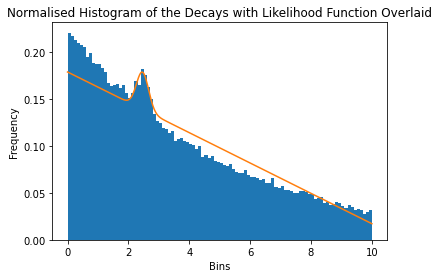

In [17]:
#Checking to see how good the fit

def function_linear(f,mean,da):
    """This function defines the combined normal distribution and polynomial"""
    sigma = 0.2
    background = 1+(da*values) # linear function
    background_norm = 1/(10+(50*da)) # linear normalisation
    gauss = np.exp(-np.square(values-mean)/(2*np.square(sigma)))
    gauss_norm = 1/(np.sqrt(2*np.pi)*sigma)
    total = (f*background*background_norm)+((1-f)*gauss*gauss_norm)
    
    return total

values = np.linspace(0,10,1000)

plt.hist(data,bins=100,density=True)
plt.plot(values,function_linear(np.asarray(ml1.values)[0],np.asarray(ml1.values)[1],np.asarray(ml1.values)[2]))
plt.title('Normalised Histogram of the Decays with Likelihood Function Overlaid')
plt.xlabel("Bins")
plt.ylabel('Frequency')
plt.show()

#As we can see, the fit is very bad as the line doesn't correspond with the background at all.
#The linear function is not an appropriate approximation for the background.

## Discussion

It can be seen that the polynomial background produces a smaller systematic error than the linear one; the polynomial background producing an error $\pm0.0042$ and the linear background $\pm0.0332$. This implies that the polynomial background is much more accurate than the linear background which can be visually confirmed by comparing the fits superimposed over the histograms. The polynomial histogram matches the background curve pretty well whereas the linear one does not fit it well at all. Therefore, the total error for the linear background is more than 2 times greater than the total error for the polynomial background ($\pm0.0365$ vs $\pm0.0162$).